# Estimating the Announcement Effect of the Volcker Rule
In this project we estimated the announcement effect of Volcker Rule (new banking regulation in US) on US banks. More specifically, we analyzed:

(i) Did the banks decrease their trading assets after the announcement of the new regulation?

(ii) If they responded to the regulation, which banks responded most and which banks least? Why?

(iii) Remember robustness, and how should banks or regulators use these results?


# Structure

1. Naïve Models
2. Baseline Models
3. Difference-in-difference Models
4. Robustness test - we adopted propensity score matching (PSM) to reduce the bias due to confounding variables potentially in the estimation of the treatment effect. 

# Conclusion
The results show us that the BHCs having higher trading asset ratios in the pre-DFA period had a greater reduction in their trading asset ratios with the passenger of the Volcker Rule. 

In [60]:
# enable output for scrolling
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

## Bookmarks

* Go to <a href=#model1_1_1>model1.1.1</a> Table 3 Panel A Model(1)
* Go to <a href=#model1_1_2>model1.1.2</a> Table 3 Panel A Model(2)
* Go to <a href=#model1_1_3>model1.1.3</a> Table 3 Panel A Model(3)
* Go to <a href=#model1_1_4>model1.1.4</a> Table 3 Panel A Model(4)
* Go to <a href=#model1_2_1>model1.2.1</a> Table 3 Panel B Model(1)
* Go to <a href=#model1_2_2>model1.2.2</a> Table 3 Panel B Model(2)
* Go to <a href=#model1_2_3>model1.2.3</a> Table 3 Panel B Model(3)
* Go to <a href=#model1_2_4>model1.2.4</a> Table 3 Panel B Model(4)

<i>For each model, we've developed two identical models using statsmodels and linearmodels, respectively.</i> <br></br>
* Based on our observations, the model displayed in the paper is done with the "statsmodels" package. The model displayed in the presentation slide is done with the "linearmodels" package.
* The package "linearmodels" provides us with standard errors clustered at BHC level.
* As the R squared in panel analysis is not very informative, we adopted the R squared from OLS (in the "statsmodels" package).

In [1]:
# !pip install pandas==0.23.4
import pandas as pd
import numpy as np
from datetime import datetime

from linearmodels.panel import PanelOLS
from linearmodels import BetweenOLS, FirstDifferenceOLS, PooledOLS
import statsmodels.api as sm
from statsmodels.formula.api import ols

from pymatch.Matcher import Matcher

import warnings # supress warnings
warnings.filterwarnings('ignore')

## 0. Data Preprocessing

In [2]:
df = pd.read_csv('DiD_data.csv')

In [3]:
 # adjust data types
df['rssd9999'] = pd.to_datetime(df['rssd9999'], format='%Y%m%d')
df['dep_cpp_bankquarter'] = df['dep_cpp_bankquarter'].astype('category')
df['rssd9001'] = df['rssd9001'].astype('category')
df['after_DFA_1'] = df['after_DFA_1'].astype('category')
df['treat_3_b_avg'] = df['treat_3_b_avg'].astype('category')

In [4]:
# create new variables (according to Table 1 in paper)
df["Affect"] = np.nan
df["Affect_pre_2007"] = np.nan
start, end = datetime.strptime("20030401", "%Y%m%d"), datetime.strptime("20061231", "%Y%m%d")
df['pre_2007'] = df['rssd9999'].apply(lambda x:1 if (x<=end and x>=start) else 0)
def calAVG(data):
    data["Affect_pre_2007"] = np.mean(data['bhc_avgtradingratio'][data['pre_2007'] == 1])
    data["Affect"] = np.mean(data['bhc_avgtradingratio'][data['after_DFA_1'] == 0])
    return data
df = df.groupby('rssd9001').apply(calAVG)
del df['pre_2007']

In [5]:
df.describe()

bhc_avgtradingratio      dep_roa1  dep_leverage  dep_lnassets  \
count         41442.000000  56938.000000  57017.000000  61771.000000   
mean              0.002650      0.001844      0.093518     13.516361   
std               0.020015      0.006116      0.042513      1.354361   
min               0.000000     -0.387137     -0.762281      5.888878   
25%               0.000000      0.001246      0.073928     12.621573   
50%               0.000000      0.002209      0.090160     13.233317   
75%               0.000000      0.003119      0.108184     13.948256   
max               0.429727      0.934277      1.157965     21.669949   

       dep_creditrisk_total3       dep_cir  dep_depositratio  \
count           44432.000000  42382.000000      79172.000000   
mean                0.027758      0.531455          0.681883   
std                 0.033980      0.355984          0.112038   
min                 0.000000    -12.478261          0.000000   
25%                 0.009764      0.413383          0.635417   
50%                 0.018046      0.502336          0.696680   
75%                 0.032604      0.615253          0.750985   
max                 0.734222     45.933334          0.998093   

       dep_loans_REratio  dep_liquidity        Affect  Affect_pre_2007  
count       44432.000000   55159.000000  81560.000000     79701.000000  
mean            0.735931       0.053559      0.001927         0.001365  
std             0.160457       0.051830      0.016979         0.012976  
min             0.000000       0.000230      0.000000         0.000000  
25%             0.655918       0.024569      0.000000         0.000000  
50%             0.764127       0.036075      0.000000         0.000000  
75%             0.848875       0.062095      0.000000         0.000000  
max             1.010109       0.843543      0.429426         0.389452

In [6]:
# df_copy = df.copy(deep=True)

#### Modifying index for linearmodels

In [9]:
# add column 'rssd9001' to index
new_df = df.set_index('rssd9001', append=True)
# swap indexes
new_df.index = new_df.index.swaplevel(0,1)
new_df.head()

rssd9999  bhc_avgtradingratio treat_3_b_avg after_DFA_1  \
rssd9001                                                               
1020180  0 2004-09-30                  0.0             0           0   
         1 2004-12-31                  0.0             0           0   
         2 2005-03-31                  0.0             0           0   
         3 2005-06-30                  0.0             0           0   
         4 2005-09-30                  0.0             0           0   

            dep_roa1  dep_leverage  dep_lnassets  dep_creditrisk_total3  \
rssd9001                                                                  
1020180  0  0.002772      0.081957     15.601202               0.013304   
         1  0.003045      0.082480     15.630583               0.009732   
         2  0.002616      0.082074     15.644925               0.011830   
         3  0.002647      0.081712     15.679702               0.013654   
         4  0.002867      0.082944     15.661868               0.012456   

             dep_cir  dep_depositratio  dep_loans_REratio  dep_liquidity  \
rssd9001                                                                   
1020180  0  0.463811          0.561805           0.593738       0.024337   
         1  0.456392          0.557617           0.601763       0.025446   
         2  0.444011          0.556980           0.600700       0.025153   
         3  0.433771          0.571642           0.601042       0.023670   
         4  0.400985          0.577408           0.581438       0.029793   

           dep_cpp_bankquarter  Affect  Affect_pre_2007  
rssd9001                                                 
1020180  0                   0     0.0              0.0  
         1                   0     0.0              0.0  
         2                   0     0.0              0.0  
         3                   0     0.0              0.0  
         4                   0     0.0              0.0

## 1. Modeling

## 1.1 Panel A Baseline tests

### Without Controls + Without FE, Table 3 Panel A Model(1)
<a name='model1_1_1' /></a>

#### statsmodels:

In [10]:
regout1_a_1 = ols('bhc_avgtradingratio ~ after_DFA_1', df).fit()
regout1_a_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
========================================================================
Model:              OLS                 Adj. R-squared:     0.000       
Dependent Variable: bhc_avgtradingratio AIC:                -206578.3563
Date:               2020-10-11 20:05    BIC:                -206561.0922
No. Observations:   41442               Log-Likelihood:     1.0329e+05  
Df Model:           1                   F-statistic:        6.419       
Df Residuals:       41440               Prob (F-statistic): 0.0113      
R-squared:          0.000               Scale:              0.00040055  
--------------------------------------------------------------------------
                    Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------------
Intercept           0.0024     0.0001   19.2066   0.0000   0.0022   0.0027
after_DFA_1[T.1]    0.0005     0.0002    2.5335   0.0113   0.0001   0.0009
------------------------------------------------------------------------
Omnibus:              71532.559      Durbin-Watson:         0.198       
Prob(Omnibus):        0.000          Jarque-Bera (JB):      57471366.578
Skew:                 12.333         Prob(JB):              0.000       
Kurtosis:             183.761        Condition No.:         2           
========================================================================

"""

In [33]:
print('r_squared:', regout1_a_1.rsquared)
print('coef of "After DFA":', regout1_a_1.params[-1])

r_squared: 0.00015486972219069806
coef of "After DFA": 0.0005076381572939418


#### linearmodels:

In [11]:
exog_vars = ['after_DFA_1']
exog = sm.add_constant(new_df[exog_vars])
model1_a_1 = PooledOLS(new_df['bhc_avgtradingratio'], exog)  
print(model1_a_1.fit(cov_type='clustered',cluster_entity=True))

                           PooledOLS Estimation Summary                          
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.0002
Estimator:                   PooledOLS   R-squared (Between):              0.0003
No. Observations:                41442   R-squared (Within):              -0.0032
Date:                 Sun, Oct 11 2020   R-squared (Overall):              0.0002
Time:                         20:05:45   Log-likelihood                 1.033e+05
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      6.4188
Entities:                         2473   P-value                           0.0113
Avg Obs:                        16.758   Distribution:                 F(1,41440)
Min Obs:                        1.0000                                           
Max Obs:                        40.000   F-statistic (robust):             0.6934
                

 ### With Controls + Without FE, Table 3 Panel A Model(2)
 <a name='model1_1_2' /></a>

#### statsmodels:

In [12]:
regout1_a_2 = ols('bhc_avgtradingratio ~ after_DFA_1 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter', df).fit()
regout1_a_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:               OLS                 Adj. R-squared:     0.234       
Dependent Variable:  bhc_avgtradingratio AIC:                -211879.8449
Date:                2020-10-11 20:05    BIC:                -211793.8721
No. Observations:    40026               Log-Likelihood:     1.0595e+05  
Df Model:            9                   F-statistic:        1358.       
Df Residuals:        40016               Prob (F-statistic): 0.00        
R-squared:           0.234               Scale:              0.00029407  
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept                -0.0204   0.0015 -13.6006 0.0000 -0.0233 -0.0174
after_DFA_1[T.1]         -0.0010   0.0002  -4.7023 0.0000 -0.0014 -0.0006
dep_cpp_bankquarter[T.1] -0.0016   0.0004  -4.4384 0.0000 -0.0023 -0.0009
dep_lnassets              0.0043   0.0001  59.5192 0.0000  0.0042  0.0045
dep_leverage             -0.0486   0.0025 -19.2079 0.0000 -0.0536 -0.0437
dep_liquidity            -0.0005   0.0020  -0.2403 0.8101 -0.0044  0.0035
dep_depositratio         -0.0338   0.0008 -41.6012 0.0000 -0.0353 -0.0322
dep_creditrisk_total3     0.0190   0.0027   7.1121 0.0000  0.0138  0.0242
dep_loans_REratio        -0.0139   0.0006 -23.5332 0.0000 -0.0150 -0.0127
dep_cir                   0.0008   0.0003   2.5412 0.0110  0.0002  0.0015
-------------------------------------------------------------------------
Omnibus:             63931.864       Durbin-Watson:          0.174       
Prob(Omnibus):       0.000           Jarque-Bera (JB):       43561263.910
Skew:                10.476          Prob(JB):               0.000       
Kurtosis:            163.252         Condition No.:          453         
=========================================================================

"""

In [44]:
print('r_squared:', regout1_a_2.rsquared)
print('coef of "After DFA":', regout1_a_2.params[1])

r_squared: 0.2339369835421382
coef of "After DFA": -0.000991694328788061


#### linearmodels:

In [13]:
exog_vars = ['after_DFA_1', 'dep_lnassets', 'dep_leverage', 'dep_liquidity', 'dep_depositratio', 'dep_creditrisk_total3', 'dep_loans_REratio', 'dep_cir', 'dep_cpp_bankquarter']
exog = sm.add_constant(new_df[exog_vars])
model1_a_2 = PooledOLS(new_df['bhc_avgtradingratio'], exog)  
print(model1_a_2.fit(cov_type='clustered',cluster_entity=True))

                           PooledOLS Estimation Summary                          
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.2339
Estimator:                   PooledOLS   R-squared (Between):              0.2291
No. Observations:                40026   R-squared (Within):              -0.1281
Date:                 Sun, Oct 11 2020   R-squared (Overall):              0.2339
Time:                         20:05:45   Log-likelihood                 1.059e+05
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1357.8
Entities:                         2473   P-value                           0.0000
Avg Obs:                        16.185   Distribution:                 F(9,40016)
Min Obs:                        0.0000                                           
Max Obs:                        38.000   F-statistic (robust):             3.7513
                

### With Controls + Without FE, Table 3 Panel A Model(3)
 <a name='model1_1_3' /></a>

#### statsmodels:

In [14]:
regout1_a_3 = ols('bhc_avgtradingratio ~ Affect*after_DFA_1 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter', df).fit()
regout1_a_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:               OLS                 Adj. R-squared:     0.902       
Dependent Variable:  bhc_avgtradingratio AIC:                -294083.4976
Date:                2020-10-11 20:05    BIC:                -293980.3302
No. Observations:    40026               Log-Likelihood:     1.4705e+05  
Df Model:            11                  F-statistic:        3.339e+04   
Df Residuals:        40014               Prob (F-statistic): 0.00        
R-squared:           0.902               Scale:              3.7714e-05  
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept                -0.0030   0.0005  -5.6091 0.0000 -0.0041 -0.0020
after_DFA_1[T.1]         -0.0000   0.0001  -0.3649 0.7152 -0.0002  0.0001
dep_cpp_bankquarter[T.1] -0.0002   0.0001  -1.9227 0.0545 -0.0005  0.0000
Affect                    0.9925   0.0025 402.1789 0.0000  0.9877  0.9973
Affect:after_DFA_1[T.1]  -0.1611   0.0031 -52.8163 0.0000 -0.1671 -0.1551
dep_lnassets              0.0002   0.0000   8.3413 0.0000  0.0002  0.0003
dep_leverage              0.0011   0.0009   1.2228 0.2214 -0.0007  0.0029
dep_liquidity            -0.0005   0.0007  -0.7345 0.4627 -0.0019  0.0009
dep_depositratio          0.0004   0.0003   1.3179 0.1876 -0.0002  0.0010
dep_creditrisk_total3     0.0019   0.0010   2.0228 0.0431  0.0001  0.0038
dep_loans_REratio        -0.0007   0.0002  -3.4619 0.0005 -0.0012 -0.0003
dep_cir                   0.0002   0.0001   1.8793 0.0602 -0.0000  0.0005
-------------------------------------------------------------------------
Omnibus:              51919.782      Durbin-Watson:         0.524        
Prob(Omnibus):        0.000          Jarque-Bera (JB):      103544743.501
Skew:                 6.373          Prob(JB):              0.000        
Kurtosis:             251.845        Condition No.:         1669         
=========================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [43]:
print('r_squared:', regout1_a_3.rsquared)
print('coef of "After DFA":', regout1_a_3.params[1])
print('coef of "Affect":', regout1_a_3.params[3])
print('coef of "After DFA x Affect":', regout1_a_3.params[4])

r_squared: 0.9017605248532038
coef of "After DFA": -2.7724088690420914e-05
coef of "Affect": 0.9925099668730799
coef of "After DFA x Affect": -0.1611276726678175


#### linearmodels:

In [15]:
model1_a_3 = PooledOLS.from_formula("bhc_avgtradingratio ~ 1 + Affect*after_DFA_1 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter", data=new_df) 
print(model1_a_3.fit(cov_type='clustered',cluster_entity=True))

                           PooledOLS Estimation Summary                          
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.9018
Estimator:                   PooledOLS   R-squared (Between):              0.9810
No. Observations:                40026   R-squared (Within):               0.0750
Date:                 Sun, Oct 11 2020   R-squared (Overall):              0.9018
Time:                         20:05:46   Log-likelihood                 1.471e+05
Cov. Estimator:              Clustered                                           
                                         F-statistic:                   3.339e+04
Entities:                         2473   P-value                           0.0000
Avg Obs:                        16.185   Distribution:                F(11,40014)
Min Obs:                        0.0000                                           
Max Obs:                        38.000   F-statistic (robust):           1.37e+05
                

###  With Controls + With FE, Table 3 Panel A Model(4)
 <a name='model1_1_4' /></a>

#### statsmodels:

In [23]:
# manually create a multiplication term
tmp_df = df.copy(deep=True)
tmp_df['after_DFA_1'] = df['after_DFA_1'].astype('int')
tmp_df['after_DFA_1_mul_Affect'] = tmp_df['Affect'] * tmp_df['after_DFA_1']
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('category')

In [22]:
regout1_a_4 = ols('bhc_avgtradingratio ~ after_DFA_1_mul_Affect + rssd9001 + rssd9999 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter ', tmp_df).fit()
regout1_a_4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                     OLS                        Adj. R-squared:            0.920       
Dependent Variable:        bhc_avgtradingratio        AIC:                       -300108.8235
Date:                      2020-10-11 20:17           BIC:                       -278839.1416
No. Observations:          40026                      Log-Likelihood:            1.5253e+05  
Df Model:                  2473                       F-statistic:               188.0       
Df Residuals:              37552                      Prob (F-statistic):        0.00        
R-squared:                 0.925                      Scale:                     3.0568e-05  
---------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                     0.0067   0.0028   2.3990 0.0164  0.0012  0.0121
rssd9001[T.1020201]                           0.1362   0.0025  54.6550 0.0000  0.1314  0.1411
rssd9001[T.1020340]                           0.0178   0.0016  11.0110 0.0000  0.0147  0.0210
rssd9001[T.1020395]                           0.0013   0.0025   0.5266 0.5985 -0.0036  0.0062
rssd9001[T.1020582]                           0.0019   0.0025   0.7482 0.4543 -0.0030  0.0067
rssd9001[T.1020676]                           0.0008   0.0013   0.6323 0.5272 -0.0018  0.0034
rssd9001[T.1020902]                           0.0156   0.0013  12.1192 0.0000  0.0131  0.0181
rssd9001[T.1020920]                           0.0008   0.0025   0.3027 0.7621 -0.0041  0.0056
rssd9001[T.1021570]                          -0.0033   0.0025  -1.3030 0.1926 -0.0082  0.0016
rssd9001[T.1021628]                           0.0000   0.0000   3.3851 0.0007  0.0000  0.0000
rssd9001[T.1021682]                           0.0008   0.0013   0.5939 0.5526 -0.0018  0.0034
rssd9001[T.1021879]                          -0.0001   0.0023  -0.0232 0.9815 -0.0046  0.0045
rssd9001[T.1022166]                           0.0017   0.0025   0.6820 0.4953 -0.0032  0.0066
rssd9001[T.1022269]                           0.0037   0.0025   1.4592 0.1445 -0.0013  0.0086
rssd9001[T.1022661]                          -0.0000   0.0000  -4.4337 0.0000 -0.0000 -0.0000
rssd9001[T.1022764]                           0.0020   0.0013   1.5769 0.1148 -0.0005  0.0045
rssd9001[T.1022924]                          -0.0000   0.0000  -3.9951 0.0001 -0.0000 -0.0000
rssd9001[T.1022997]                           0.0034   0.0025   1.3892 0.1648 -0.0014  0.0083
rssd9001[T.1023154]                           0.0027   0.0014   1.9325 0.0533 -0.0000  0.0055
rssd9001[T.1023220]                          -0.0000   0.0000  -4.0339 0.0001 -0.0000 -0.0000
rssd9001[T.1023239]                           0.0019   0.0013   1.4843 0.1377 -0.0006  0.0045
rssd9001[T.1025309]                           0.0057   0.0013   4.4808 0.0000  0.0032  0.0082
rssd9001[T.1025541]                          -0.0001   0.0013  -0.1038 0.9173 -0.0026  0.0024
rssd9001[T.1025608]                           0.0024   0.0013   1.8126 0.0699 -0.0002  0.0050
rssd9001[T.1025662]                           0.0015   0.0014   1.0929 0.2745 -0.0012  0.0041
rssd9001[T.1026632]                           0.0065   0.0018   3.5688 0.0004  0.0029  0.0101
rssd9001[T.1026801]                           0.0036   0.0013   2.7591 0.0058  0.0010  0.0062
rssd9001[T.1027004]                           0.0063   0.0013   4.8262 0.0000  0.0038  0.0089
rssd9001[T.1027518]                           0.0038   0.0013   2.9343 0.0033  0.0012  0.0063
rssd9001[T.1027947]                           0.0034   0.0025   1.3444 0.1788 -0.0015  0.0083
rssd9001[T.1027992]               

In [45]:
print('r_squared:', regout1_a_4.rsquared)
print('coef of "After DFA x Affect":', regout1_a_4.params[-8])

r_squared: 0.925272154590944
coef of "After DFA x Affect": -0.20234751961868105


#### linearmodels:

In [17]:
# reset index
new_df = df.set_index(["rssd9001","rssd9999"], inplace=False)

In [18]:
model1_a_4 = PanelOLS.from_formula("bhc_avgtradingratio ~ 1 + Affect*after_DFA_1  + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter + EntityEffects + TimeEffects", drop_absorbed=True, data=new_df)  
print(model1_a_4.fit(cov_type='clustered', cluster_entity=True))

                           PanelOLS Estimation Summary                           
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.0824
Estimator:                    PanelOLS   R-squared (Between):             -0.1946
No. Observations:                40026   R-squared (Within):               0.0805
Date:                 Sun, Oct 11 2020   R-squared (Overall):             -0.2049
Time:                         20:09:40   Log-likelihood                 1.525e+05
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      374.56
Entities:                         2473   P-value                           0.0000
Avg Obs:                        16.185   Distribution:                 F(9,37552)
Min Obs:                        0.0000                                           
Max Obs:                        38.000   F-statistic (robust):             4.9886
                

## 1.2 Panel B Robustness tests

### DID, With Controls + With FE, Table 3 Panel B Model(1)
 <a name='model1_2_1' /></a>

#### statsmodels:

In [95]:
# manually create a multiplication term
tmp_df = df.copy(deep=True)
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('int')
tmp_df['treat_3_b_avg'] = tmp_df['treat_3_b_avg'].astype('int')
tmp_df['after_DFA_1_mul_treat_3_b_avg'] = tmp_df['after_DFA_1'] * tmp_df['treat_3_b_avg']
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('category')
tmp_df['treat_3_b_avg'] = tmp_df['treat_3_b_avg'].astype('category')
tmp_df['after_DFA_1_mul_treat_3_b_avg'] = tmp_df['after_DFA_1_mul_treat_3_b_avg'].astype('category')

In [96]:
regout1_b_1 = ols('bhc_avgtradingratio ~ after_DFA_1 + treat_3_b_avg + treat_3_b_avg*after_DFA_1 + rssd9001 + rssd9999 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter', tmp_df).fit()
regout1_b_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                     OLS                        Adj. R-squared:            0.918       
Dependent Variable:        bhc_avgtradingratio        AIC:                       -298856.1734
Date:                      2020-10-11 21:36           BIC:                       -277586.4915
No. Observations:          40026                      Log-Likelihood:            1.5190e+05  
Df Model:                  2473                       F-statistic:               181.8       
Df Residuals:              37552                      Prob (F-statistic):        0.00        
R-squared:                 0.923                      Scale:                     3.1540e-05  
---------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                     0.0059   0.0028   2.0993 0.0358  0.0004  0.0115
after_DFA_1[T.1]                              0.0010   0.0002   4.3528 0.0000  0.0006  0.0015
treat_3_b_avg[T.1]                            0.1306   0.0010 124.7830 0.0000  0.1285  0.1326
rssd9001[T.1020201]                           0.0054   0.0023   2.3907 0.0168  0.0010  0.0098
rssd9001[T.1020340]                           0.0169   0.0016  10.2701 0.0000  0.0137  0.0201
rssd9001[T.1020395]                           0.0012   0.0025   0.4920 0.6227 -0.0037  0.0062
rssd9001[T.1020582]                           0.0019   0.0025   0.7497 0.4534 -0.0031  0.0069
rssd9001[T.1020676]                           0.0007   0.0013   0.5179 0.6045 -0.0019  0.0033
rssd9001[T.1020902]                           0.0129   0.0013   9.9130 0.0000  0.0104  0.0155
rssd9001[T.1020920]                           0.0007   0.0025   0.2701 0.7871 -0.0043  0.0057
rssd9001[T.1021570]                          -0.0030   0.0025  -1.1700 0.2420 -0.0080  0.0020
rssd9001[T.1021628]                           0.0000   0.0000   4.7441 0.0000  0.0000  0.0000
rssd9001[T.1021682]                           0.0008   0.0014   0.5767 0.5641 -0.0019  0.0035
rssd9001[T.1021879]                          -0.0000   0.0024  -0.0097 0.9923 -0.0047  0.0046
rssd9001[T.1022166]                           0.0016   0.0025   0.6385 0.5231 -0.0034  0.0066
rssd9001[T.1022269]                           0.0036   0.0026   1.4058 0.1598 -0.0014  0.0086
rssd9001[T.1022661]                           0.0000   0.0000   9.0930 0.0000  0.0000  0.0000
rssd9001[T.1022764]                           0.0020   0.0013   1.5376 0.1242 -0.0005  0.0045
rssd9001[T.1022924]                          -0.0000   0.0000  -1.6668 0.0956 -0.0000  0.0000
rssd9001[T.1022997]                           0.0033   0.0025   1.3229 0.1859 -0.0016  0.0083
rssd9001[T.1023154]                           0.0025   0.0014   1.7388 0.0821 -0.0003  0.0053
rssd9001[T.1023220]                          -0.0000   0.0000  -1.3437 0.1791 -0.0000  0.0000
rssd9001[T.1023239]                           0.0018   0.0013   1.3457 0.1784 -0.0008  0.0044
rssd9001[T.1025309]                           0.0051   0.0013   3.9151 0.0001  0.0025  0.0076
rssd9001[T.1025541]                           0.0000   0.0013   0.0139 0.9889 -0.0025  0.0026
rssd9001[T.1025608]                           0.0023   0.0013   1.7147 0.0864 -0.0003  0.0049
rssd9001[T.1025662]                           0.0017   0.0014   1.2013 0.2297 -0.0010  0.0044
rssd9001[T.1026632]                           0.0065   0.0019   3.4890 0.0005  0.0028  0.0101
rssd9001[T.1026801]                           0.0034   0.0013   2.5493 0.0108  0.0008  0.0060
rssd9001[T.1027004]                           0.0057   0.0013   4.2840 0.0000  0.0031  0.0083
rssd9001[T.1027518]               

In [97]:
print('r_squared:', regout1_b_1.rsquared)
print('coef of "After DFA x Affected BHC":', regout1_b_1.params[-8])

r_squared: 0.9228964983109023
coef of "After DFA x Affected BHC": -0.023372290150885898


#### linearmodels:

In [26]:
model1_b_1 = PanelOLS.from_formula("bhc_avgtradingratio ~ 1 + after_DFA_1*treat_3_b_avg  + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter + EntityEffects + TimeEffects", drop_absorbed=True, data=df)  
print(regout1_b_1.fit(cov_type='clustered',cluster_entity=True))

                           PanelOLS Estimation Summary                           
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.0532
Estimator:                    PanelOLS   R-squared (Between):             -0.0663
No. Observations:                40026   R-squared (Within):               0.0520
Date:                 Thu, Oct 08 2020   R-squared (Overall):             -0.0776
Time:                         15:28:24   Log-likelihood                 1.519e+05
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      234.46
Entities:                         2473   P-value                           0.0000
Avg Obs:                        16.185   Distribution:                 F(9,37552)
Min Obs:                        0.0000                                           
Max Obs:                        38.000   F-statistic (robust):             1.9886
                

R^2=0.918

### DID+PSM, Table 3 Panel B Model(2)
 <a name='model1_2_2' /></a>

#### Step 1: PSM

https://github.com/benmiroglio/pymatch

In [7]:
# data prep
test = df[df.treat_3_b_avg == 1]
control = df[df.treat_3_b_avg == 0]

In [8]:
m = Matcher(test, control, yvar = 'treat_3_b_avg', exclude=['rssd9001', 'rssd9999', 'bhc_avgtradingratio', 'treat_3_b_avg',
       'after_DFA_1', 'Affect','Affect_pre_2007'])

Formula:
treat_3_b_avg ~ dep_roa1+dep_leverage+dep_lnassets+dep_creditrisk_total3+dep_cir+dep_depositratio+dep_loans_REratio+dep_liquidity+dep_cpp_bankquarter
n majority: 38237
n minority: 546


In [9]:
np.random.seed(1012)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 91.66%


The average accuracy scores the "separability" of our data. The high accuracy score here justifies the need for matching, and also that the observable features are adequete for matching the data.

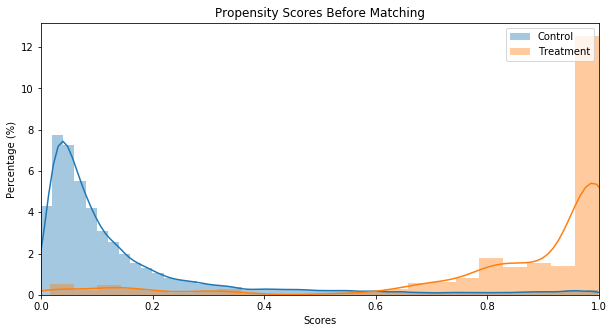

In [10]:
m.predict_scores()
m.plot_scores()

We need to ensure our threshold is small enough such that we get close matches and retain most (or all) of our data in the minority group.Below we tune the threshold using method="random". This matches a random profile that is within the threshold as there could be many. This is much faster than the alternative method "min", which finds the closest match for every minority record

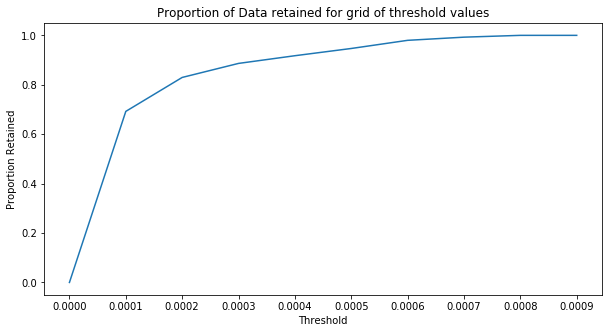

In [11]:
m.tune_threshold(method='random')

In [12]:
m.match(method="min", nmatches=1, threshold=0.0007)

In [13]:
m.record_frequency()

freq  n_records
0     1        826
1     2         42
2     3         17
3     4          6
4     5          2
5     7          2
6    11          1
7    19          1
8    53          1

In [14]:
m.assign_weight_vector()

In [15]:
m.matched_data.sort_values("match_id").head(6)

record_id  weight rssd9001   rssd9999  bhc_avgtradingratio  \
0            0     1.0  1020201 2004-09-30             0.126453   
872      28484     1.0  2291727 2013-06-30             0.000975   
1            1     1.0  1020201 2004-12-31             0.139026   
649       4878     1.0  1070345 2005-09-30             0.002420   
2            2     1.0  1020201 2005-03-31             0.130043   
797      17982     0.5  1199844 2014-12-31             0.005773   

     treat_3_b_avg after_DFA_1  dep_roa1  dep_leverage  dep_lnassets  \
0                1           0  0.002906      0.070028     18.610798   
872              0           1  0.001924      0.096206     13.449108   
1                1           0  0.002053      0.074122     18.764626   
649              0           0  0.003805      0.090187     18.465733   
2                1           0  0.002237      0.076953     18.768549   
797              0           1  0.002162      0.107195     18.056152   

     dep_creditrisk_total3   dep_cir  dep_depositratio  dep_loans_REratio  \
0                 0.013813  0.339097          0.390303           0.758043   
872               0.019571  0.714023          0.188077           0.453434   
1                 0.014689  0.414206          0.358281           0.647956   
649               0.012555  0.385858          0.447399           0.460942   
2                 0.015002  0.357776          0.357660           0.651144   
797               0.009112  0.630276          0.429196           0.288430   

     dep_liquidity dep_cpp_bankquarter    Affect  Affect_pre_2007    scores  \
0         0.044461                   0  0.134151         0.134151  0.900119   
872       0.106132                   0  0.002409         0.002490  0.900103   
1         0.042322                   0  0.134151         0.134151  0.954137   
649       0.030521                   0  0.007679         0.002846  0.954160   
2         0.045373                   0  0.134151         0.134151  0.951927   
797       0.100545                   1  0.005369         0.002492  0.951662   

     match_id  
0           0  
872         0  
1           1  
649         1  
2           2  
797         2

In [16]:
len(m.matched_data)

1092

#### Access matching

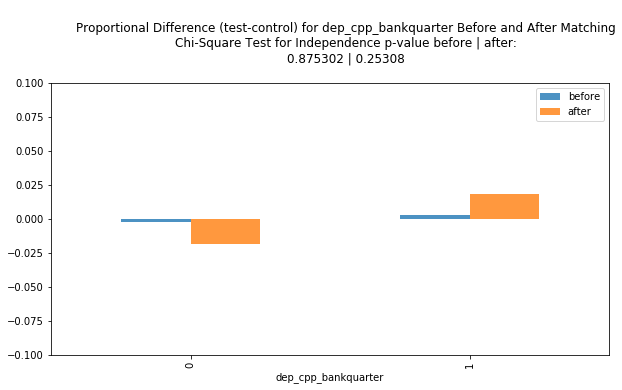

In [17]:
categorical_results = m.compare_categorical(return_table=True)

In [18]:
categorical_results

var    before    after
0  dep_cpp_bankquarter  0.875302  0.25308

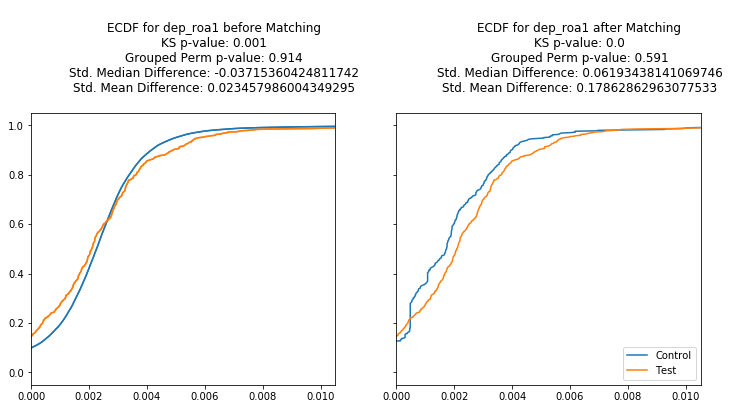

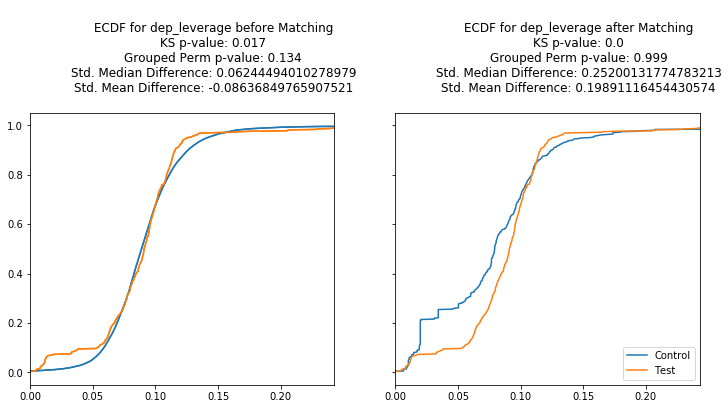

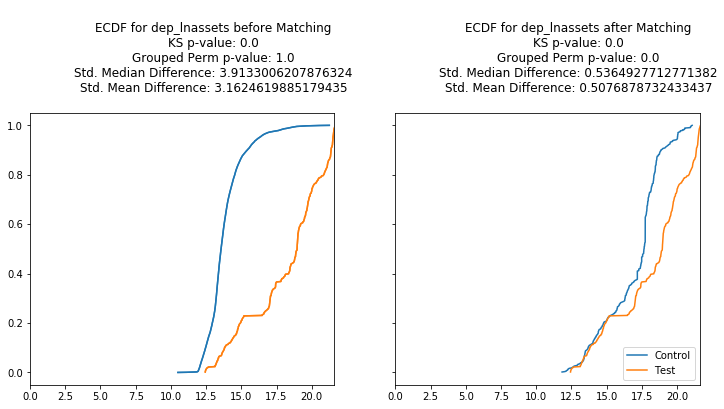

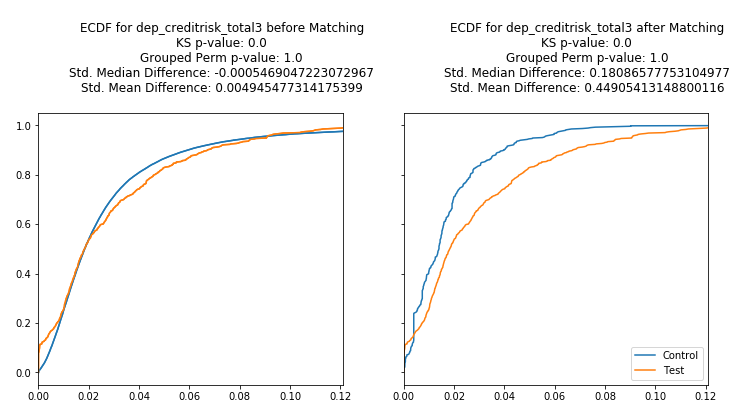

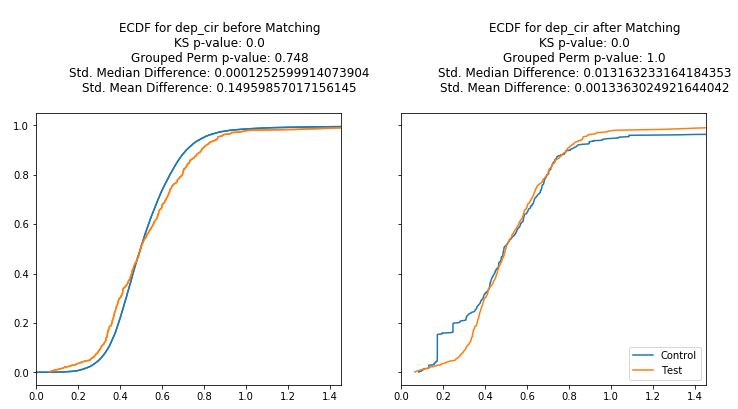

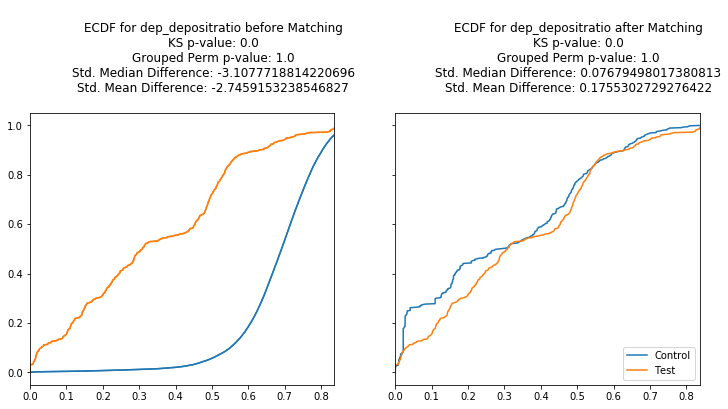

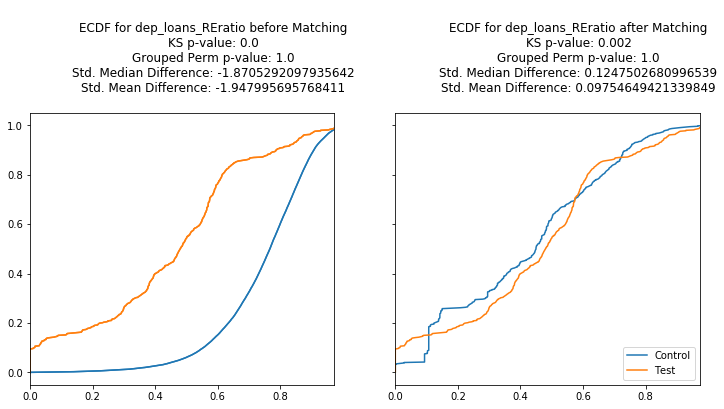

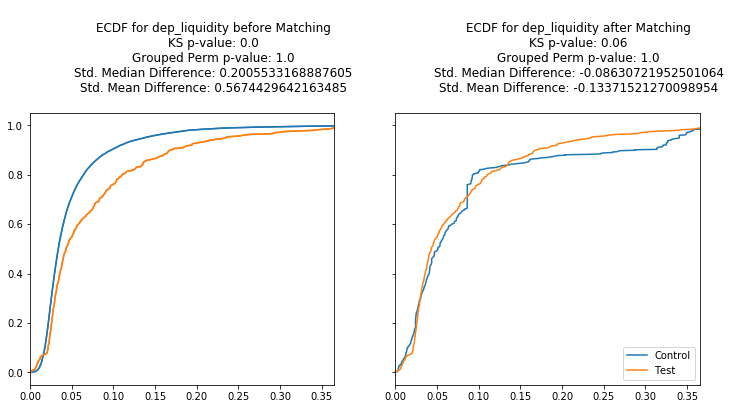

In [19]:
cc = m.compare_continuous(return_table=True)

In [20]:
cc

var  ks_before  ks_after  grouped_chisqr_before  \
0               dep_roa1      0.001     0.000                  0.914   
1           dep_leverage      0.017     0.000                  0.134   
2           dep_lnassets      0.000     0.000                  1.000   
3  dep_creditrisk_total3      0.000     0.000                  1.000   
4                dep_cir      0.000     0.000                  0.748   
5       dep_depositratio      0.000     0.000                  1.000   
6      dep_loans_REratio      0.000     0.002                  1.000   
7          dep_liquidity      0.000     0.060                  1.000   

   grouped_chisqr_after  std_median_diff_before  std_median_diff_after  \
0                 0.591               -0.037154               0.061934   
1                 0.999                0.062445               0.252001   
2                 0.000                3.913301               0.536493   
3                 1.000               -0.000547               0.180866   
4                 1.000                0.000125               0.013163   
5                 1.000               -3.107772               0.076795   
6                 1.000               -1.870529               0.124750   
7                 1.000                0.200553              -0.086307   

   std_mean_diff_before  std_mean_diff_after  
0              0.023458             0.178629  
1             -0.086368             0.198911  
2              3.162462             0.507688  
3              0.004945             0.449054  
4              0.149599             0.001336  
5             -2.745915             0.175530  
6             -1.947996             0.097546  
7              0.567443            -0.133715

#### Step 2: DID

In [21]:
df_psm = m.matched_data.copy(deep=True)

#### statsmodels:

In [22]:
# manually create a multiplication term
tmp_df = df_psm.copy(deep=True)
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('int')
tmp_df['treat_3_b_avg'] = tmp_df['treat_3_b_avg'].astype('int')
tmp_df['after_DFA_1_mul_treat_3_b_avg'] = tmp_df['after_DFA_1'] * tmp_df['treat_3_b_avg']
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('category')
tmp_df['treat_3_b_avg'] = tmp_df['treat_3_b_avg'].astype('category')
tmp_df['after_DFA_1_mul_treat_3_b_avg'] = tmp_df['after_DFA_1_mul_treat_3_b_avg'].astype('category')

In [23]:
regout1_b_2 = ols('bhc_avgtradingratio ~ after_DFA_1*treat_3_b_avg + rssd9001 + rssd9999 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter', tmp_df).fit()
regout1_b_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                        Adj. R-squared:            0.894     
Dependent Variable:          bhc_avgtradingratio        AIC:                       -4766.6920
Date:                        2020-10-15 22:56           BIC:                       -3712.5853
No. Observations:            1092                       Log-Likelihood:            2594.3    
Df Model:                    210                        F-statistic:               44.67     
Df Residuals:                881                        Prob (F-statistic):        0.00      
R-squared:                   0.914                      Scale:                     0.00062690
---------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                     0.0410   0.0720   0.5696 0.5691 -0.1003  0.1824
after_DFA_1[T.1]                              0.0131   0.0069   1.9075 0.0568 -0.0004  0.0266
treat_3_b_avg[T.1]                            0.1293   0.0122  10.5539 0.0000  0.1052  0.1533
rssd9001[T.1020201]                           0.0389   0.0114   3.4084 0.0007  0.0165  0.0613
rssd9001[T.1020340]                           0.0144   0.0153   0.9415 0.3467 -0.0156  0.0445
rssd9001[T.1020395]                          -0.0000   0.0000  -0.0891 0.9290 -0.0000  0.0000
rssd9001[T.1020582]                          -0.0000   0.0000  -1.5545 0.1204 -0.0000  0.0000
rssd9001[T.1020676]                          -0.0000   0.0000  -0.2531 0.8002 -0.0000  0.0000
rssd9001[T.1020902]                          -0.0026   0.0271  -0.0962 0.9234 -0.0559  0.0506
rssd9001[T.1020920]                          -0.0000   0.0000  -0.8373 0.4026 -0.0000  0.0000
rssd9001[T.1021570]                           0.0000   0.0000   1.2187 0.2233 -0.0000  0.0000
rssd9001[T.1021628]                          -0.0000   0.0000  -1.0039 0.3157 -0.0000  0.0000
rssd9001[T.1021682]                          -0.0122   0.0271  -0.4489 0.6536 -0.0654  0.0411
rssd9001[T.1021879]                          -0.0000   0.0000  -0.8620 0.3889 -0.0000  0.0000
rssd9001[T.1022166]                          -0.0000   0.0000  -0.4435 0.6575 -0.0000  0.0000
rssd9001[T.1022269]                           0.0000   0.0000   1.2654 0.2061 -0.0000  0.0000
rssd9001[T.1022661]                          -0.0000   0.0000  -1.3715 0.1706 -0.0000  0.0000
rssd9001[T.1022764]                           0.0000   0.0000   0.5254 0.5994 -0.0000  0.0000
rssd9001[T.1022924]                          -0.0000   0.0000  -1.5672 0.1174 -0.0000  0.0000
rssd9001[T.1022997]                           0.0000   0.0000   0.9260 0.3547 -0.0000  0.0000
rssd9001[T.1023154]                           0.0000   0.0000   1.3462 0.1786 -0.0000  0.0000
rssd9001[T.1023220]                           0.0000   0.0000   1.0248 0.3058 -0.0000  0.0000
rssd9001[T.1023239]                          -0.0000   0.0000  -0.4765 0.6338 -0.0000  0.0000
rssd9001[T.1025309]                          -0.0000   0.0000  -0.1997 0.8417 -0.0000  0.0000
rssd9001[T.1025541]                          -0.0000   0.0000  -0.1010 0.9196 -0.0000  0.0000
rssd9001[T.1025608]                          -0.0107   0.0177  -0.6027 0.5469 -0.0454  0.0241
rssd9001[T.1025662]                           0.0000   0.0000   1.4520 0.1469 -0.0000  0.0000
rssd9001[T.1026632]                           0.0245   0.0168   1.4604 0.1445 -0.0084  0.0574
rssd9001[T.1026801]                          -0.0000   0.0000  -0.8206 0.4121 -0.0000  0.0000
rssd9001[T.1027004]                           0.0134   0.0187   0.7150 0.4748 -0.0234  0.0501
rssd9001[T.1027518]               

In [24]:
print('r_squared:', regout1_b_2.rsquared)
print('coef of "After DFA x Affected BHC":', regout1_b_2.params[-8])

r_squared: 0.9141534847958597
coef of "After DFA x Affected BHC": -0.02981808093554504


#### linearmodels:

In [25]:
# set index for PanelOLS
df_psm = df_psm.set_index(["rssd9001","rssd9999"])

In [26]:
model1_b_2 = PanelOLS.from_formula("bhc_avgtradingratio ~ 1 + after_DFA_1*treat_3_b_avg + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter + EntityEffects + TimeEffects", drop_absorbed=True, data=df_psm)  
print(model1_b_2.fit(cov_type='clustered',cluster_entity=True))

                           PanelOLS Estimation Summary                           
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.1284
Estimator:                    PanelOLS   R-squared (Between):             -1.4223
No. Observations:                 1092   R-squared (Within):               0.1540
Date:                 Thu, Oct 15 2020   R-squared (Overall):             -0.4883
Time:                         22:56:42   Log-likelihood                    2594.3
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      14.421
Entities:                         2432   P-value                           0.0000
Avg Obs:                        0.4490   Distribution:                   F(9,881)
Min Obs:                        0.0000                                           
Max Obs:                        137.00   F-statistic (robust):             2.1454
                

### Using pre-2007 Affect  Table 3 Panel B Model(3)
 <a name='model1_2_3' /></a>

#### statsmodels:

In [99]:
# manually create a multiplication term
tmp_df = df.copy(deep=True)
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('int')
tmp_df['treat_3_b_avg'] = tmp_df['treat_3_b_avg'].astype('int')
tmp_df['after_DFA_1_mul_Affect_pre_2007'] = tmp_df['Affect_pre_2007'] * tmp_df['after_DFA_1']
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('category')

In [100]:
np.seterr(divide='ignore', invalid='ignore')
regout1_b_3 = ols('bhc_avgtradingratio ~ after_DFA_1_mul_Affect_pre_2007 + rssd9001 + rssd9999 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter', tmp_df).fit()
regout1_b_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                     OLS                        Adj. R-squared:            0.887       
Dependent Variable:        bhc_avgtradingratio        AIC:                       -292382.4670
Date:                      2020-10-11 21:39           BIC:                       -271790.4346
No. Observations:          38783                      Log-Likelihood:            1.4860e+05  
Df Model:                  2403                       F-statistic:               127.5       
Df Residuals:              36379                      Prob (F-statistic):        0.00        
R-squared:                 0.894                      Scale:                     2.9333e-05  
---------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                     0.0061   0.0028   2.1765 0.0295  0.0006  0.0115
rssd9001[T.1020201]                           0.1361   0.0024  55.6911 0.0000  0.1313  0.1409
rssd9001[T.1020340]                           0.0178   0.0016  11.1793 0.0000  0.0146  0.0209
rssd9001[T.1020395]                           0.0007   0.0024   0.2833 0.7770 -0.0041  0.0055
rssd9001[T.1020582]                           0.0009   0.0024   0.3661 0.7143 -0.0039  0.0057
rssd9001[T.1020676]                           0.0005   0.0013   0.3659 0.7145 -0.0021  0.0030
rssd9001[T.1020902]                           0.0162   0.0013  12.8538 0.0000  0.0137  0.0187
rssd9001[T.1020920]                           0.0003   0.0024   0.1261 0.8996 -0.0045  0.0051
rssd9001[T.1021570]                          -0.0024   0.0025  -0.9880 0.3232 -0.0073  0.0024
rssd9001[T.1021628]                          -0.0000   0.0000  -7.3069 0.0000 -0.0000 -0.0000
rssd9001[T.1021682]                           0.0002   0.0013   0.1755 0.8607 -0.0023  0.0028
rssd9001[T.1021879]                          -0.0002   0.0023  -0.0828 0.9340 -0.0047  0.0043
rssd9001[T.1022166]                           0.0009   0.0025   0.3541 0.7232 -0.0039  0.0057
rssd9001[T.1022269]                           0.0021   0.0025   0.8573 0.3913 -0.0027  0.0070
rssd9001[T.1022661]                           0.0000   0.0000   6.9172 0.0000  0.0000  0.0000
rssd9001[T.1022764]                           0.0012   0.0013   0.9751 0.3295 -0.0012  0.0037
rssd9001[T.1022924]                          -0.0000   0.0000  -6.0556 0.0000 -0.0000 -0.0000
rssd9001[T.1022997]                           0.0020   0.0024   0.8288 0.4072 -0.0028  0.0068
rssd9001[T.1023154]                           0.0016   0.0014   1.1420 0.2535 -0.0011  0.0043
rssd9001[T.1023220]                          -0.0000   0.0000  -7.3385 0.0000 -0.0000 -0.0000
rssd9001[T.1023239]                           0.0011   0.0013   0.8842 0.3766 -0.0014  0.0036
rssd9001[T.1025309]                           0.0050   0.0012   3.9808 0.0001  0.0025  0.0074
rssd9001[T.1025541]                          -0.0002   0.0012  -0.1732 0.8625 -0.0027  0.0022
rssd9001[T.1025608]                           0.0028   0.0013   2.1523 0.0314  0.0002  0.0053
rssd9001[T.1025662]                           0.0004   0.0013   0.3208 0.7484 -0.0022  0.0030
rssd9001[T.1026632]                           0.0075   0.0018   4.1773 0.0000  0.0040  0.0110
rssd9001[T.1026801]                           0.0024   0.0013   1.8919 0.0585 -0.0001  0.0049
rssd9001[T.1027004]                           0.0066   0.0013   5.1505 0.0000  0.0041  0.0092
rssd9001[T.1027518]                           0.0037   0.0013   2.9833 0.0029  0.0013  0.0062
rssd9001[T.1027947]                           0.0019   0.0025   0.7768 0.4373 -0.0029  0.0067
rssd9001[T.1027992]               

In [101]:
print('r_squared:', regout1_b_3.rsquared)
print("""coef of "After DFA x Affect (pre-2007)":""", regout1_b_3.params[-8])

r_squared: 0.893895685565754
coef of "After DFA x Affect (pre-2007)": -0.20513745414123066


#### linearmodels:

In [91]:
# reset index
new_df = df.set_index(["rssd9001","rssd9999"], inplace=False)

In [93]:
model1_b_3 = PanelOLS.from_formula("bhc_avgtradingratio ~ 1 + after_DFA_1*Affect_pre_2007 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter + EntityEffects + TimeEffects", drop_absorbed=True, data=new_df)  
print(model1_b_3.fit(cov_type='clustered',cluster_entity=True))

                           PanelOLS Estimation Summary                           
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.0645
Estimator:                    PanelOLS   R-squared (Between):             -0.0778
No. Observations:                38783   R-squared (Within):               0.0639
Date:                 Sun, Oct 11 2020   R-squared (Overall):             -0.1128
Time:                         21:32:30   Log-likelihood                 1.486e+05
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      278.81
Entities:                         2433   P-value                           0.0000
Avg Obs:                        15.940   Distribution:                 F(9,36379)
Min Obs:                        0.0000                                           
Max Obs:                        38.000   F-statistic (robust):             4.1098
                

### pre-2007 Affect+Exclusion Table 3 Panel B Model(4)
 <a name='model1_2_4' /></a>
 
 * "We test the robustness of our results when excluding all entities that have zero trading books "——p16

In [122]:
# Exclude non-trading BHCs
exclude_BHC = set(df['rssd9001'][(df['bhc_avgtradingratio'] == 0)&(df['after_DFA_1'] == 0)])
trading_df = df[~df['rssd9001'].isin(exclude_BHC)]

#### statsmodels:

In [128]:
# manually create a multiplication term
tmp_df = trading_df.copy(deep=True)
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('int')
tmp_df['treat_3_b_avg'] = tmp_df['treat_3_b_avg'].astype('int')
tmp_df['after_DFA_1_mul_Affect_pre_2007'] = tmp_df['Affect_pre_2007'] * tmp_df['after_DFA_1']
tmp_df['after_DFA_1'] = tmp_df['after_DFA_1'].astype('category')

In [129]:
np.seterr(divide='ignore', invalid='ignore')
regout1_b_4= ols('bhc_avgtradingratio ~ after_DFA_1_mul_Affect_pre_2007 + rssd9001 + rssd9999 + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter', tmp_df).fit()
regout1_b_4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                      OLS                        Adj. R-squared:            0.932      
Dependent Variable:         bhc_avgtradingratio        AIC:                       -14151.3674
Date:                       2020-10-11 21:57           BIC:                       -13281.9839
No. Observations:           2527                       Log-Likelihood:            7224.7     
Df Model:                   148                        F-statistic:               236.7      
Df Residuals:               2378                       Prob (F-statistic):        0.00       
R-squared:                  0.936                      Scale:                     0.00020447 
---------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                     0.0585   0.0291   2.0065 0.0449  0.0013  0.1156
rssd9001[T.1020201]                           0.1068   0.0070  15.3068 0.0000  0.0931  0.1205
rssd9001[T.1020340]                          -0.0161   0.0038  -4.2184 0.0000 -0.0236 -0.0086
rssd9001[T.1020395]                          -0.0000   0.0000  -4.3335 0.0000 -0.0000 -0.0000
rssd9001[T.1020582]                           0.0000   0.0000   8.0450 0.0000  0.0000  0.0000
rssd9001[T.1020676]                          -0.0000   0.0000  -5.0084 0.0000 -0.0000 -0.0000
rssd9001[T.1020902]                          -0.0000   0.0000  -4.4084 0.0000 -0.0000 -0.0000
rssd9001[T.1020920]                           0.0000   0.0000   5.5363 0.0000  0.0000  0.0000
rssd9001[T.1021570]                           0.0000   0.0000   7.5719 0.0000  0.0000  0.0000
rssd9001[T.1021628]                          -0.0000   0.0000  -0.3768 0.7063 -0.0000  0.0000
rssd9001[T.1021682]                          -0.0000   0.0000  -5.6043 0.0000 -0.0000 -0.0000
rssd9001[T.1021879]                           0.0000   0.0000   5.1228 0.0000  0.0000  0.0000
rssd9001[T.1022166]                           0.0000   0.0000   5.9704 0.0000  0.0000  0.0000
rssd9001[T.1022269]                           0.0000   0.0000   6.1119 0.0000  0.0000  0.0000
rssd9001[T.1022661]                           0.0000   0.0000   8.6539 0.0000  0.0000  0.0000
rssd9001[T.1022764]                           0.0000   0.0000   4.5717 0.0000  0.0000  0.0000
rssd9001[T.1022924]                          -0.0000   0.0000  -4.3335 0.0000 -0.0000 -0.0000
rssd9001[T.1022997]                          -0.0000   0.0000  -5.6622 0.0000 -0.0000 -0.0000
rssd9001[T.1023154]                           0.0000   0.0000   3.4664 0.0005  0.0000  0.0000
rssd9001[T.1023220]                           0.0000   0.0000   7.5915 0.0000  0.0000  0.0000
rssd9001[T.1023239]                          -0.0000   0.0000  -5.1130 0.0000 -0.0000 -0.0000
rssd9001[T.1025309]                          -0.0250   0.0027  -9.2602 0.0000 -0.0303 -0.0197
rssd9001[T.1025541]                           0.0000   0.0000   7.3847 0.0000  0.0000  0.0000
rssd9001[T.1025608]                          -0.0335   0.0035  -9.6083 0.0000 -0.0403 -0.0266
rssd9001[T.1025662]                           0.0000   0.0000   5.6345 0.0000  0.0000  0.0000
rssd9001[T.1026632]                          -0.0326   0.0047  -6.9375 0.0000 -0.0418 -0.0234
rssd9001[T.1026801]                           0.0000   0.0000   1.5791 0.1144 -0.0000  0.0000
rssd9001[T.1027004]                          -0.0233   0.0029  -7.9369 0.0000 -0.0291 -0.0176
rssd9001[T.1027518]                          -0.0294   0.0027 -10.8343 0.0000 -0.0347 -0.0241
rssd9001[T.1027947]                          -0.0000   0.0000  -3.2854 0.0010 -0.0000 -0.0000
rssd9001[T.1027992]               

In [130]:
print('r_squared:', regout1_b_4.rsquared)
print("""coef of "After DFA x Affect (pre-2007)":""", regout1_b_4.params[-8])

r_squared: 0.9364388082663194
coef of "After DFA x Affect (pre-2007)": -0.21930755769663396


#### linearmodels:

In [123]:
# reset index
new_df = trading_df.set_index(["rssd9001","rssd9999"], inplace=False)

In [124]:
model1_b_4 = PanelOLS.from_formula("bhc_avgtradingratio ~ 1 + after_DFA_1*Affect_pre_2007  + dep_lnassets + dep_leverage + dep_liquidity + dep_depositratio + dep_creditrisk_total3 + dep_loans_REratio + dep_cir + dep_cpp_bankquarter + EntityEffects + TimeEffects", drop_absorbed=True, data=new_df)  
print(model1_b_4.fit(cov_type='clustered',cluster_entity=True))

                           PanelOLS Estimation Summary                           
Dep. Variable:     bhc_avgtradingratio   R-squared:                        0.1374
Estimator:                    PanelOLS   R-squared (Between):             -0.0417
No. Observations:                 2527   R-squared (Within):               0.1385
Date:                 Sun, Oct 11 2020   R-squared (Overall):             -0.0773
Time:                         21:51:37   Log-likelihood                    7224.7
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      42.091
Entities:                         2392   P-value                           0.0000
Avg Obs:                        1.0564   Distribution:                  F(9,2378)
Min Obs:                        0.0000                                           
Max Obs:                        38.000   F-statistic (robust):             2.9079
                